# GemPy 3: gravity inversion for normal fault model

Based on `GemPy3_Tutorial_XX_fault_gravity.ipynb`

For installation, see the first notebook - here only repeated if running on Google Colab.

In [1]:
# !pip install gempy --pre

In [2]:
# For 3D plots
# !sudo apt install libgl1-mesa-glx xvfb
# !pip install pyvista

import pyvista as pv
# pv.start_xvfb()

GemPy is now separated into different modules to keep the dependencies low. This means that the base version `gempy-engine` is very lean. To enable possibilities to view the created models, we also need to install the `gempy-viewer` module:

In [3]:
# !pip install gempy_viewer

With these two modules installed (only required the first time on each system), we can import the modules into the notebook, as usual:

In [4]:
# Importing GemPy and viewer
import gempy as gp
import gempy_viewer as gpv
import gempy_engine
from gempy_engine.core.backend_tensor import BackendTensor

Setting Backend To: AvailableBackends.numpy


And for some additional steps in this notebook:

In [5]:
# Auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd 

Packages for inversion

In [6]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer.inspect import get_dependencies
from pyro.infer import MCMC, NUTS, Predictive
from pyro.infer.autoguide import init_to_mean, init_to_median, init_to_value
import arviz as az

## Step 1: Model setup

In a first step, we define the model domain. In the standard setting, this as simple as defining model extent and grid resolution (i.e.: grid elements in each axis direction). We also need to define a structural frame (more on that later) - for now, simply filled with a default structure:

In [7]:
try:
    del(geo_model)
except NameError:  
    pass

resolution = [150, 10, 150]
extent = [0, 200, -100, 100, -100, 0]

# %%


geo_model: gp.data.GeoModel = gp.create_geomodel(
    project_name='Fault model',
    extent=extent,
    resolution=resolution,
    # refinement=6,
    structural_frame=gp.data.StructuralFrame.initialize_default_structure()
)

In [8]:
interpolation_options = geo_model.interpolation_options
interpolation_options.mesh_extraction = True
interpolation_options.kernel_options.range = .7
interpolation_options.kernel_options.c_o = 3
interpolation_options.kernel_options.compute_condition_number = True

## Step 2: Add geological data



### Add surface points

In [9]:
gp.add_surface_points(
    geo_model=geo_model,
    x=[40, 60, 120, 140],
    y=[0, 0, 0, 0],
    z=[-50, -50, -60, -60],
    elements_names=['surface1', 'surface1', 'surface1', 'surface1']
)

gp.add_orientations(
    geo_model=geo_model,
    x=[130],
    y=[0],
    z=[-50],
    elements_names=['surface1'],
    pole_vector=[[0, 0, 1.]]
)

# Define second element
element2 = gp.data.StructuralElement(
    name='surface2',
    color=next(geo_model.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([120]),
        y=np.array([0]),
        z=np.array([-40]),
        names='surface2'
    ),
    orientations=gp.data.OrientationsTable.initialize_empty()
)

# Add second element to structural frame
geo_model.structural_frame.structural_groups[0].append_element(element2)

# add fault
# Calculate orientation from point values
fault_point_1 = (80, -20)
fault_point_2 = (110, -80)

# calculate angle
angle = np.arctan((fault_point_2[0] - fault_point_1[0]) / (fault_point_2[1] - fault_point_1[1]))

x = np.cos(angle)
z = - np.sin(angle)

element_fault = gp.data.StructuralElement(
    name='fault1',
    color=next(geo_model.structural_frame.color_generator),
    surface_points=gp.data.SurfacePointsTable.from_arrays(
        x=np.array([fault_point_1[0], fault_point_2[0]]),
        y=np.array([0, 0]),
        z=np.array([fault_point_1[1], fault_point_2[1]]),
        names='fault1'
    ),
    orientations=gp.data.OrientationsTable.from_arrays(
        x=np.array([fault_point_1[0]]),
        y=np.array([0]),
        z=np.array([fault_point_1[1]]),
        G_x=np.array([x]),
        G_y=np.array([0]),
        G_z=np.array([z]),
        names='fault1'
    )
)

group_fault = gp.data.StructuralGroup(
    name='Fault1',
    elements=[element_fault],
    structural_relation=gp.data.StackRelationType.FAULT,
    fault_relations=gp.data.FaultsRelationSpecialCase.OFFSET_ALL
)

# Insert the fault group into the structural frame:
geo_model.structural_frame.insert_group(0, group_fault)

## Compute model

Setting Backend To: AvailableBackends.numpy
Condition number: 7604.373179902182. Is positive definite: False
(array([], dtype=int64),)


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_engine/modules/solver/solver_interface.py:102: UserWarning: The covariance matrix is not positive definite
  warnings.warn('The covariance matrix is not positive definite')


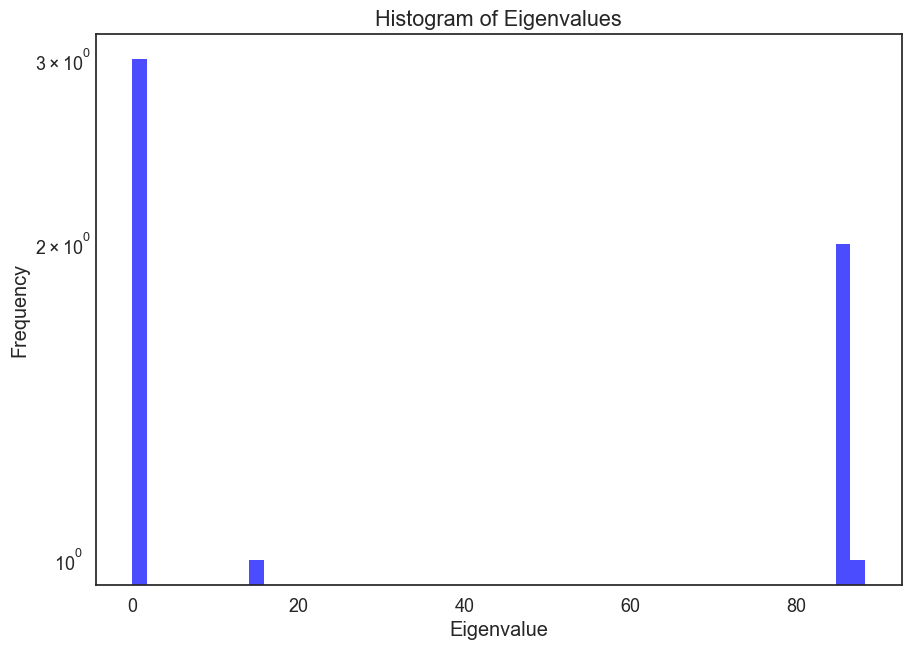

Condition number: 7793.9035924332065. Is positive definite: False
(array([], dtype=int64),)


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_engine/modules/solver/solver_interface.py:102: UserWarning: The covariance matrix is not positive definite
  warnings.warn('The covariance matrix is not positive definite')


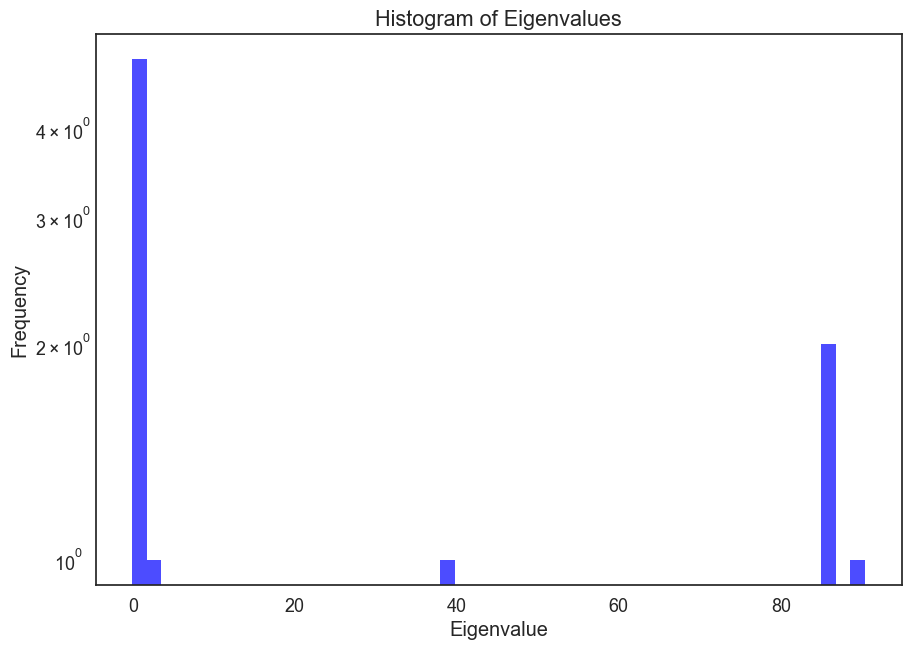

/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/gempy_engine/API/dual_contouring/multi_scalar_dual_contouring.py:48: UserWarning: Fancy triangulation only works with regular grid of resolution [2,2,2]. Defaulting to regular triangulation
  warnings.warn("Fancy triangulation only works with regular grid of resolution [2,2,2]. Defaulting to regular triangulation")


Solutions(1 Octree Levels, 3 DualContouringMeshes)

In [10]:
geo_model.update_transform(gp.data.GlobalAnisotropy.NONE)
gp.compute_model(geo_model)

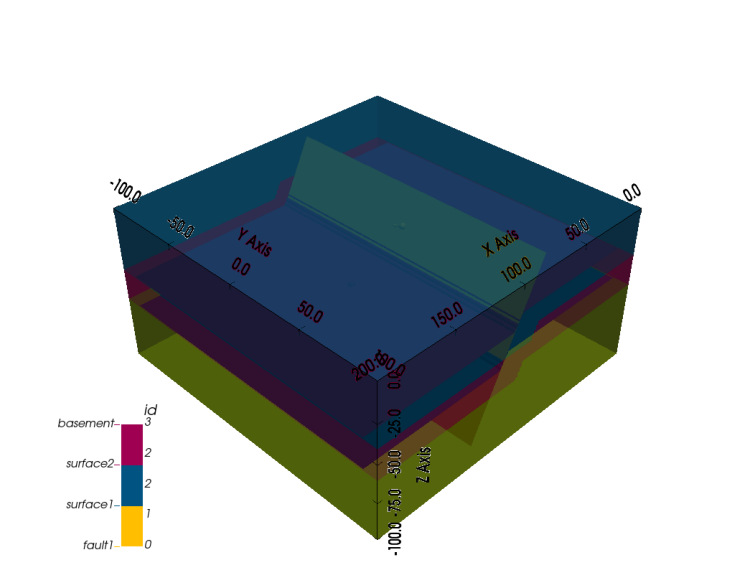

In [11]:

# %%
# Visualize the computed geological model in 3D
gempy_vista = gpv.plot_3d(
    model=geo_model,
    show=True,
    kwargs_plot_structured_grid={'opacity': 0.8},
    image=True
)


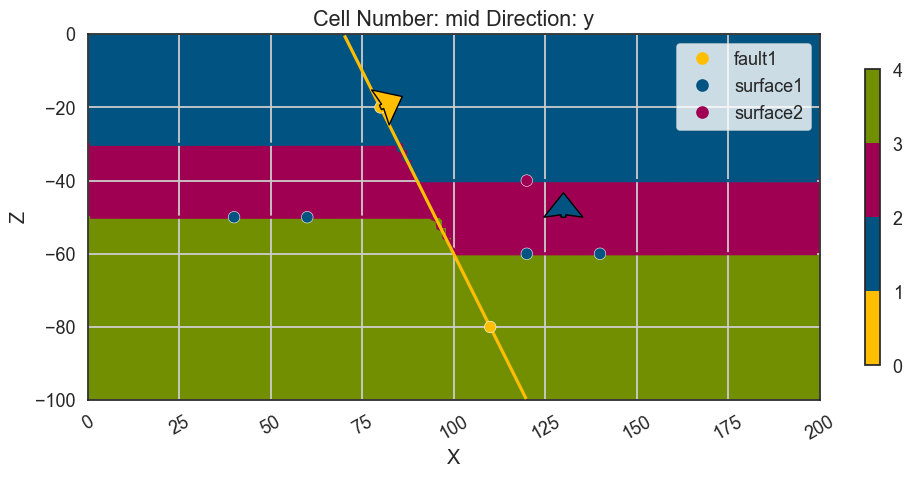

In [12]:
# Preview the model's input data:
p2d = gpv.plot_2d(geo_model, show=False)
plt.grid()
plt.show()

In [13]:
interpolation_options.mesh_extraction = False
interpolation_options.number_octree_levels = 1
geo_model.grid.set_inactive("topography")
geo_model.grid.set_inactive("regular")

array([False, False, False, False, False])

## Calculate gravity

In [14]:
BackendTensor.change_backend_gempy(engine_backend=gp.data.AvailableBackends.PYTORCH, dtype="float64")

Setting Backend To: AvailableBackends.PYTORCH


Set device positions

In [15]:
interesting_columns = pd.DataFrame()
x_vals = np.arange(20,191,10)
interesting_columns['X'] = x_vals
interesting_columns['Y'] = np.zeros_like(x_vals)
# Configuring the data correctly is key for accurate gravity calculations.
device_location = interesting_columns[['X', 'Y']]
device_location['Z'] = 0  # Add a Z-coordinate
# Set up a centered grid for geophysical calculations
# This grid will be used for gravity gradient calculations.
gp.set_centered_grid(
    grid=geo_model.grid,
    centers=device_location,
    resolution=np.array([75, 5, 150]),
    radius=np.array([150, 10, 300])
)

# Calculate the gravity gradient using GemPy
# Gravity gradient data is critical for geophysical modeling and inversion.
gravity_gradient = gp.calculate_gravity_gradient(geo_model.grid.centered_grid)
densities_tensor = torch.tensor([2., 2., 2.6, 2.],dtype=torch.float64)


# Set geophysics input for the GemPy model
# Configuring this input is crucial for the forward gravity calculation.
geo_model.geophysics_input = gp.data.GeophysicsInput(
    tz=torch.tensor(gravity_gradient, dtype=torch.float64),
    densities=densities_tensor
)

Active grids: ['centered']


In [16]:

# Compute the geological model with geophysical data
# This computation integrates the geological model with gravity data.
sol = gp.compute_model(
    gempy_model=geo_model,
    engine_config=gp.data.GemPyEngineConfig(
        backend=gp.data.AvailableBackends.PYTORCH,
        dtype='float64'
    )
)
grav = - sol.gravity
#grav[0].backward(retain_graph=True)
grav

Setting Backend To: AvailableBackends.PYTORCH


Condition number: 7604.3731799023.
Condition number: 7793.903592433205.


tensor([2.0752, 2.0751, 2.0746, 2.0737, 2.0722, 2.0691, 2.0648, 2.0597, 2.0556,
        2.0530, 2.0520, 2.0519, 2.0522, 2.0524, 2.0529, 2.0533, 2.0536, 2.0540],
       dtype=torch.float64)

(0.0, 200.0)

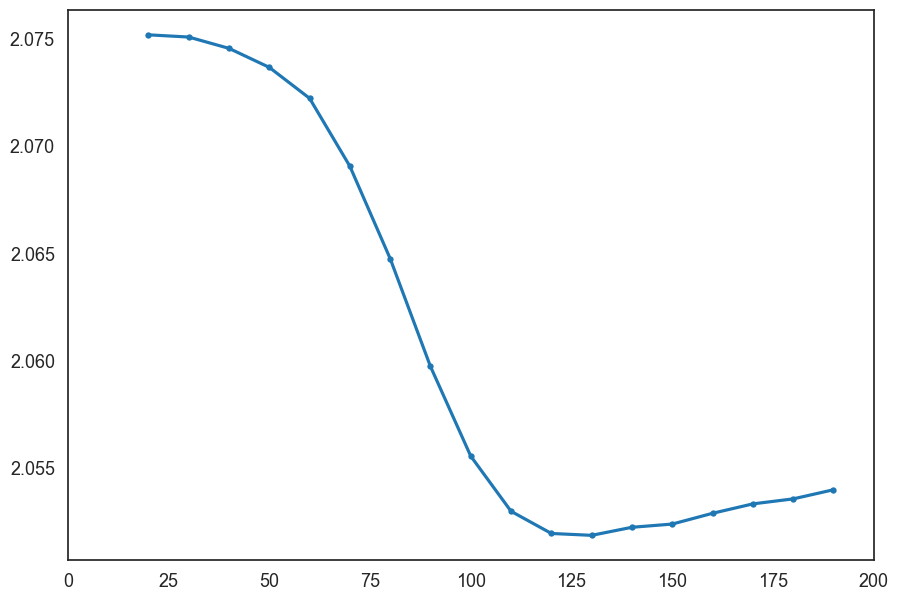

In [17]:
plt.plot(x_vals, grav.detach().numpy(), '.-')
plt.xlim([0,200])

## Plot model and gravity solution

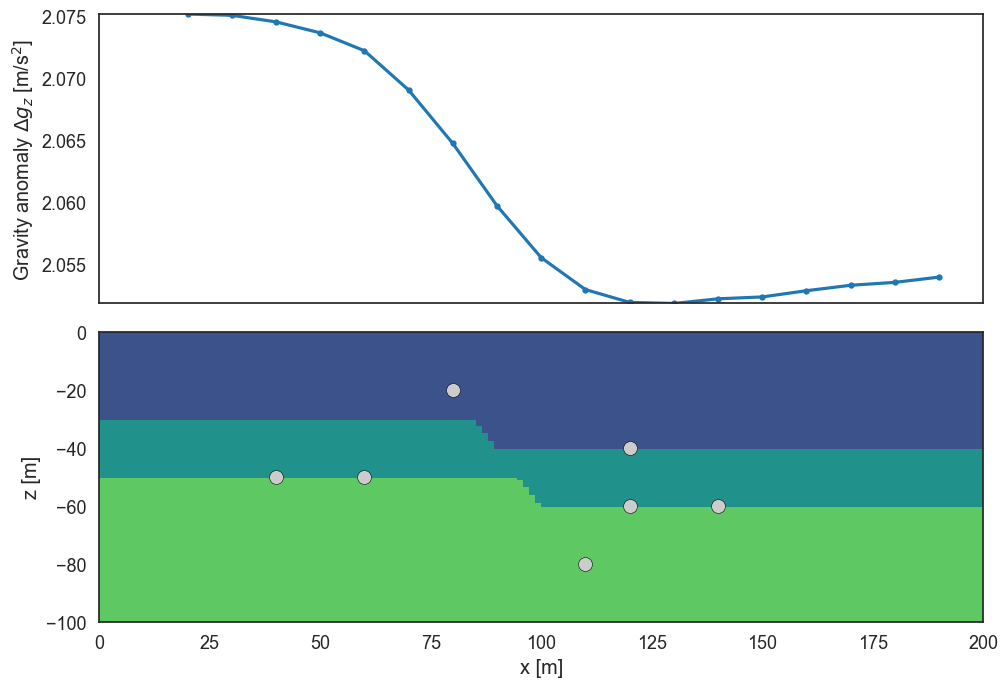

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

blocks = geo_model.solutions.raw_arrays.lith_block.reshape(resolution)

def plot_model_and_grav(blocks, grav, **kwds):
    # Assuming the setup variables x_vals, grav, and blocks are defined.
    x_min, x_max = 0, 200
    y_min, y_max = -100, 0

    vmin = kwds.get("v_min", 1)
    vmax = kwds.get("v_max", 5)



    grav_min = kwds.get("grav_min", grav.min())
    grav_max = kwds.get("grav_max", grav.max())

    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    try:
        ax1.plot(x_vals, grav.detach().numpy(), '.-')
    except AttributeError:
        ax1.plot(x_vals, grav, '.-')
        
    if grav_min:
        ax1.set_ylim([grav_min, grav_max])

    ax1.set_ylabel("Gravity anomaly $\Delta g_z$ [m/s$^2$]")

    # Add a transparent gray rectangle to the left side of the plot
    # rect = patches.Rectangle((0, grav_min), width=50, height=grav_max-grav_min, facecolor='gray', alpha=0.2)
    # ax1.add_patch(rect)
    # Add a transparent gray rectangle to the left side of the plot
    # rect = patches.Rectangle((150, grav_min), width=50, height=grav_max-grav_min, facecolor='gray', alpha=0.2)
    # ax1.add_patch(rect)

    ax2 = fig.add_subplot(212, sharex=ax1)

    # Correctly define your grid edges
    y_edges = np.linspace(y_min, y_max, blocks.shape[2]+1)
    x_edges = np.linspace(x_min, x_max, blocks.shape[0]+1)  # This should be corrected if it was incorrect

    # Making sure x_edges and y_edges are correctly sized
    assert len(x_edges) == blocks.shape[0] + 1, "x_edges does not match expected length"
    assert len(y_edges) == blocks.shape[2] + 1, "y_edges does not match expected length"

    # Ensure blocks[:, 5, :].T is correctly shaped relative to x_edges and y_edges
    c = ax2.pcolor(x_edges, y_edges, blocks[:, 5, :].T, cmap='viridis', vmin=vmin, vmax=vmax)
    # c = ax2.pcolor(blocks[:, 5, :].T, cmap='RdYlBu_r') # , vmin=1, vmax=2)

    # plot input data if given in kwds:
    if "input_data" in kwds.keys():
        plt.scatter(kwds["input_data"]['X'], kwds["input_data"]['Z'], color='#CCCCCC', edgecolors='black', s=100)

    # remove ticks from upper plot
    plt.setp(ax1.get_xticklabels(), visible=False)

    ax2.set_xlabel("x [m]")
    ax2.set_ylabel("z [m]")

    # Add a transparent gray rectangle to the left side of the plot
    # rect = patches.Rectangle((0, -100), width=50, height=100, facecolor='white', alpha=0.2)
    # ax2.add_patch(rect)
    # rect = patches.Rectangle((150, -100), width=50, height=100, facecolor='white', alpha=0.2)
    # ax2.add_patch(rect)

    # Adjust the subplot layout to prevent the subplots from overlapping
    plt.subplots_adjust(hspace=0.1)
    plt.subplots_adjust(left=0.1, right=.95, bottom=0.1, top=0.95)

    plt.close()

    return fig

input_data = geo_model.surface_points.df
fig = plot_model_and_grav(blocks, grav.detach().numpy(), input_data=input_data)
fig

In [19]:
input_data

,X,Y,Z,id,nugget
0,80.0,0.0,-20.0,58055100,0.00001
1,110.0,0.0,-80.0,58055100,0.00001
2,40.0,0.0,-50.0,95767484,0.00001
3,60.0,0.0,-50.0,95767484,0.00001
4,120.0,0.0,-60.0,95767484,0.00001
5,140.0,0.0,-60.0,95767484,0.00001
6,120.0,0.0,-40.0,30863008,0.00001


## Set up Pyro model

In [20]:
# Define hyperparameters for the Bayesian geological model
# Use first: lateral position of fault only
fault_1_x = torch.tensor(80.)
fault_2_x = torch.tensor(110.)

### Probabilistic model

@Miguel: how to adjust for input points as stochastic variables?

In [21]:
# Define the Pyro probabilistic model for inversion
# def model(y_obs_list, interpolation_input):
#     """
#     Pyro model representing the probabilistic aspects of the geological model.
#     """
#     prior_mean = 2.62
#     mu_density = pyro.sample(
#         name=r'$\mu_{density}$',
#         fn=dist.Normal(prior_mean, torch.tensor(0.5, dtype=torch.float64))
#     )
#     geo_model.geophysics_input.densities = torch.index_put(
#         input=prior_tensor,
#         indices=(torch.tensor([3]),),
#         values=mu_density
#     )
#     geo_model.solutions = gempy_engine.compute_model(
#         interpolation_input=interpolation_input,
#         options=geo_model.interpolation_options,
#         data_descriptor=geo_model.input_data_descriptor,
#         geophysics_input=geo_model.geophysics_input
#     )
#     simulated_geophysics = geo_model.solutions.gravity
#     pyro.deterministic(r'$\mu_{gravity}$', simulated_geophysics)
#     pyro.sample(
#         name="obs",
#         fn=dist.MultivariateNormal(simulated_geophysics, covariance_matrix),
#         obs=y_obs_list
#     )

In [22]:
y_obs_list = grav



test_list=[]
#test_list.append({"update":"interface_data","id":3, "direction":"Z", "prior_distribution":"normal","normal":{"mean":torch.tensor(0.0,dtype=torch.float64), "std":torch.tensor(0.1,dtype=torch.float64)}})
test_list.append({"update":"gravity","id":2, "prior_distribution":"normal","normal":{"mean":torch.tensor(3.0,dtype=torch.float64), "std":torch.tensor(0.5,dtype=torch.float64)}})
#test_list.append({"update":"gravity","id":2, "prior_distribution":"uniform","uniform":{"min":torch.tensor(2.5,dtype=torch.float64), "max":torch.tensor(3.5,dtype=torch.float64)}})


Condition number: 7604.3731799023.
Condition number: 7793.903592433207.


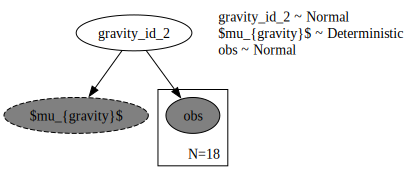

In [23]:
pyro.clear_param_store()
def model_test(y_obs_list, interpolation_input_):
    ''' 
        This Pyro model represents the probabilistic aspects of the geological model.
        Args:
            y_obs_list: observed data
            interpolation_input_: It is a list of dictionary which contains the information about
                                 Index of the point need to be updated, direction in which
                                 we want to update, distribution we want to use for prior and its
                                 parameters. 
    '''
    
    Random_variable ={} # Create a dictionary which can store all the random variable of our model
    # Obtain the interpolation data of the gempy for modification
    interpolation_input = geo_model.interpolation_input
    # Obtain gravity density
    geophysics_input= geo_model.geophysics_input
    
    # Create a random variable based on the provided dictionary used to modify input data of gempy
    for interpolation_input_data in interpolation_input_:
        # Check if user wants to create random variable based on modifying the surface points of gempy
        if interpolation_input_data["update"]=="interface_data":
            # Check what kind of distribution is needed
            if interpolation_input_data["prior_distribution"]=="normal":
                mean = interpolation_input_data["normal"]["mean"]
                std  = interpolation_input_data["normal"]["std"]
                Random_variable["SurfaceData_id_"+ str(interpolation_input_data['id'])] = pyro.sample("SurfaceData_id_"+ str(interpolation_input_data['id']), dist.Normal(mean, std))
            elif interpolation_input_data["prior_distribution"]=="uniform":
                min = interpolation_input_data["uniform"]["min"]
                max = interpolation_input_data["uniform"]["min"]
                Random_variable["SurfaceData_id_"+ str(interpolation_input_data['id'])] = pyro.sample("SurfaceData_id_"+ str(interpolation_input_data['id']), dist.Uniform(min, max))
            else:
                print("We have to include the distribution")
                
            
            # Check which co-ordinates direction we wants to allow and modify the surface point data
            if interpolation_input_data["direction"]=="X":
                interpolation_input.surface_points.sp_coords = torch.index_put(
                    interpolation_input.surface_points.sp_coords,
                    (torch.tensor([interpolation_input_data["id"]]), torch.tensor([0])),
                    Random_variable["SurfaceData_id_"+ str(interpolation_input_data['id'])])
            elif interpolation_input_data["direction"]=="Y":
                interpolation_input.surface_points.sp_coords = torch.index_put(
                    interpolation_input.surface_points.sp_coords,
                    (torch.tensor([interpolation_input_data["id"]]), torch.tensor([0])),
                    Random_variable["SurfaceData_id_"+ str(interpolation_input_data['id'])])
            elif interpolation_input_data["direction"]=="Z":
                interpolation_input.surface_points.sp_coords = torch.index_put(
                    interpolation_input.surface_points.sp_coords,
                    (torch.tensor([interpolation_input_data["id"]]), torch.tensor([0])),
                    Random_variable["SurfaceData_id_"+ str(interpolation_input_data['id'])])
            else:
                print("Wrong direction")
            #print("interpolation_options",interpolation_input.surface_points.sp_coords )
        ####################################### TODO #################################
        # Implement similarly for Orientation data
        ###############################################################################
        # Check if we want to modify the gravity data 
        elif interpolation_input_data["update"]=="gravity":
            # Choose the distribution
            if interpolation_input_data["prior_distribution"]=="normal":
                mean = interpolation_input_data["normal"]["mean"]
                std  = interpolation_input_data["normal"]["std"]
                Random_variable["gravity_id_"+ str(interpolation_input_data['id'])] = pyro.sample("gravity_id_"+ str(interpolation_input_data['id']), dist.Normal(mean, std))
            elif interpolation_input_data["prior_distribution"]=="uniform":
                min = interpolation_input_data["uniform"]["min"]
                max = interpolation_input_data["uniform"]["max"]
                Random_variable["gravity_id_"+ str(interpolation_input_data['id'])] = pyro.sample("gravity_id_"+ str(interpolation_input_data['id']), dist.Uniform(min, max))
            else:
                print("We have to include the distribution")
            
            # Modify the gravity data 
            geo_model.geophysics_input.densities = torch.index_put(
            input = densities_tensor,
            indices=(torch.tensor([interpolation_input_data["id"]]),),
            values=Random_variable["gravity_id_"+ str(interpolation_input_data['id'])])
           
            
    # # Compute the geological model
    geo_model.solutions = gempy_engine.compute_model(
        interpolation_input=interpolation_input,
        options=geo_model.interpolation_options,
        data_descriptor=geo_model.input_data_descriptor,
       geophysics_input= geo_model.geophysics_input
    )
    simulated_geophysics = - geo_model.solutions.gravity
    
    pyro.deterministic(r'$\mu_{gravity}$', simulated_geophysics)
    
    #covariance_matrix = 0.1 * torch.diag(torch.ones(simulated_geophysics.shape[0]))
    
    with pyro.plate('N='+str(y_obs_list.shape[0]), y_obs_list.shape[0]):
        obs = pyro.sample(
            name="obs",
            fn=dist.Normal(simulated_geophysics, 0.2),
            obs=y_obs_list
        )
    return obs
#dependencies = get_dependencies(model_test, model_args=(y_obs_list,test_list,))  
pyro.render_model(model_test, model_args=(y_obs_list, test_list,),render_distributions=True)

Condition number: 7604.3731799023.
Condition number: 7793.903592433207.
Condition number: 7604.3731799023.
Condition number: 7793.903592433207.
Condition number: 7604.3731799023.
Condition number: 7793.903592433207.
Condition number: 7604.3731799023.
Condition number: 7793.903592433207.
Condition number: 7604.3731799023.
Condition number: 7793.903592433207.
Condition number: 7604.3731799023.
Condition number: 7793.903592433207.
Condition number: 7604.3731799023.
Condition number: 7793.903592433207.
Condition number: 7604.3731799023.
Condition number: 7793.903592433207.
Condition number: 7604.3731799023.
Condition number: 7793.903592433207.
Condition number: 7604.3731799023.
Condition number: 7793.903592433207.
Condition number: 7604.3731799023.
Condition number: 7793.903592433207.
Condition number: 7604.3731799023.
Condition number: 7793.903592433207.


/Users/deepprakashravi/miniforge3/envs/gempy3/lib/python3.10/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


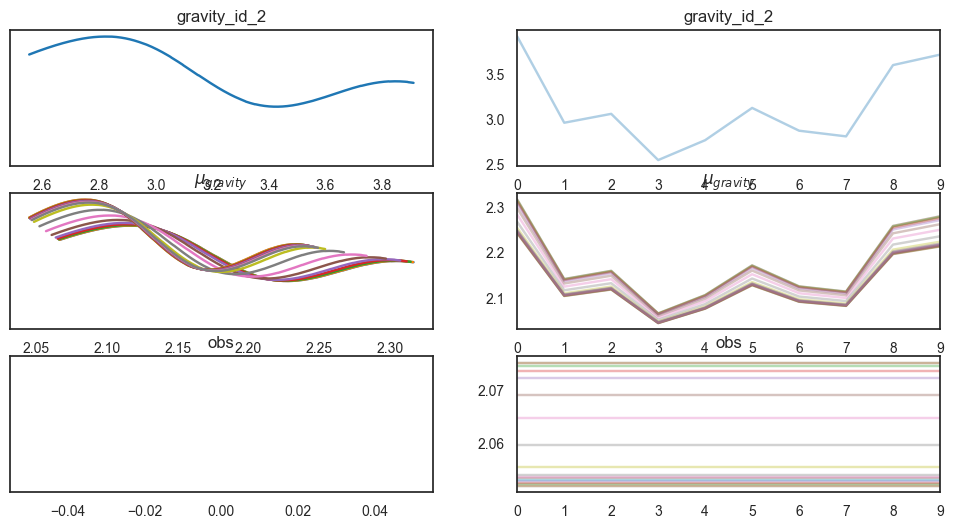

In [24]:
prior = Predictive(model_test, num_samples=10)(y_obs_list, test_list)
data = az.from_pyro(prior=prior)
az.plot_trace(data.prior)
plt.show()

In [25]:
pyro.primitives.enable_validation(is_validate=True)
nuts_kernel = NUTS(model_test)
mcmc = MCMC(nuts_kernel, num_samples=10, warmup_steps=10)
mcmc.run(y_obs_list,test_list)

Warmup:   0%|          | 0/20 [00:00, ?it/s]

Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.


Warmup:   5%|▌         | 1/20 [00:58, 58.02s/it, step size=7.19e+00, acc. prob=1.000]

Condition number: 7604.3731799023.
Condition number: 7793.903592433205.


Warmup:  10%|█         | 2/20 [01:03, 27.03s/it, step size=1.22e+00, acc. prob=0.500]

Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.


Warmup:  15%|█▌        | 3/20 [01:14, 19.70s/it, step size=1.20e-01, acc. prob=0.333]

Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.


Warmup:  20%|██        | 4/20 [01:53, 27.56s/it, step size=1.61e-01, acc. prob=0.500]

Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.


Warmup:  25%|██▌       | 5/20 [02:22, 27.92s/it, step size=2.49e-01, acc. prob=0.599]

Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.


Warmup:  30%|███       | 6/20 [02:41, 24.84s/it, step size=4.24e-01, acc. prob=0.666]

Condition number: 7604.3731799023.
Condition number: 7793.903592433205.


Warmup:  35%|███▌      | 7/20 [02:47, 18.83s/it, step size=7.97e-02, acc. prob=0.610]

Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.


Warmup:  40%|████      | 8/20 [03:28, 25.83s/it, step size=1.28e-01, acc. prob=0.654]

Condition number: 7604.3731799023.
Condition number: 7793.903592433205.


Warmup:  45%|████▌     | 9/20 [03:34, 19.63s/it, step size=2.25e-01, acc. prob=0.693]

Condition number: 7604.3731799023.
Condition number: 7793.903592433205.


Warmup:  50%|█████     | 10/20 [03:40, 15.29s/it, step size=2.25e-01, acc. prob=0.723]

Condition number: 7604.3731799023.
Condition number: 7793.903592433205.


Warmup:  55%|█████▌    | 11/20 [03:47, 12.83s/it, step size=2.25e-01, acc. prob=0.972]

Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.


Sample:  60%|██████    | 12/20 [04:28, 21.47s/it, step size=2.25e-01, acc. prob=0.985]

Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.


Sample:  65%|██████▌   | 13/20 [04:45, 20.15s/it, step size=2.25e-01, acc. prob=0.942]

Condition number: 7604.3731799023.
Condition number: 7793.903592433205.


Sample:  70%|███████   | 14/20 [04:51, 15.72s/it, step size=2.25e-01, acc. prob=0.957]

Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.


Sample:  75%|███████▌  | 15/20 [05:08, 16.10s/it, step size=2.25e-01, acc. prob=0.959]

Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.


Sample:  80%|████████  | 16/20 [05:48, 23.44s/it, step size=2.25e-01, acc. prob=0.966]

Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.


Sample:  85%|████████▌ | 17/20 [06:31, 29.29s/it, step size=2.25e-01, acc. prob=0.971]

Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.


Sample:  90%|█████████ | 18/20 [06:50, 26.07s/it, step size=2.25e-01, acc. prob=0.956]

Condition number: 7604.3731799023.
Condition number: 7793.903592433205.


Sample:  95%|█████████▌| 19/20 [06:56, 20.21s/it, step size=2.25e-01, acc. prob=0.961]

Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.
Condition number: 7604.3731799023.
Condition number: 7793.903592433205.


Sample: 100%|██████████| 20/20 [07:15, 21.75s/it, step size=2.25e-01, acc. prob=0.961]


In [26]:
posterior_samples = mcmc.get_samples()
posterior_samples

{'gravity_id_2': tensor([2.9776, 2.4130, 2.9259, 2.8596, 2.6141, 2.7898, 2.6118, 2.9437, 2.8873,
         2.6165], dtype=torch.float64)}

In [27]:
#posterior_samples = mcmc.get_samples()
#posterior_predictive = Predictive(model_test, posterior_samples)(y_obs_list, test_list)


In [28]:
# data = az.from_pyro(
#     posterior=mcmc,
#     prior=prior,
#     posterior_predictive=posterior_predictive
# )
# az.plot_trace(data)

In [29]:
posterior_samples["gravity_id_2"].mean(), posterior_samples["gravity_id_2"].std()

(tensor(2.7639, dtype=torch.float64), tensor(0.1885, dtype=torch.float64))